In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
# to make this notebook's output identical at every run
np.random.seed(42)

In [2]:
class Adam:
    def __init__(self, learning_rate=0.001):
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.learning_rate = learning_rate
        self.m = None
        self.v = None
        self.t = 0

    def update(self, w, dw):
        if self.m is None:
            self.m = np.zeros_like(dw)
            self.v = np.zeros_like(dw)
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * dw
        self.v = self.beta2 * self.v + (1 - self.beta2) * (dw ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        w -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return w


In [3]:
class Nadam:
    def __init__(self, learning_rate=0.001):
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.learning_rate = learning_rate
        self.m = None
        self.v = None
        self.t = 0

    def update(self, w, dw):
        if self.m is None:
            self.m = np.zeros_like(dw)
            self.v = np.zeros_like(dw)
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * dw
        self.v = self.beta2 * self.v + (1 - self.beta2) * (dw ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        m_prime = self.beta1 * m_hat + ((1-self.beta1)/(1-self.beta1 ** self.t)) * dw
        w -= self.learning_rate * m_prime / (np.sqrt(v_hat) + self.epsilon)
        return w

In [4]:
# Neural network with variable hidden layers
class NN:
    def __init__(self, input_size, hidden_sizes,  output_size, learning_rate,optimizer = Adam, lambda_l2 = 0.01, regression = True):
        self.hidden_sizes = hidden_sizes
        self.lambda_l2 = lambda_l2
        self.layers = []
        self.biases = []
        self.optimizer = optimizer
        self.optimizers_w = []
        self.optimizers_b = []
        self.regression = regression
    

        layer_sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(len(layer_sizes) - 1):
            # He initialization: np.random.randn * sqrt(2 / n_in)
            he_stddev = np.sqrt(2.0 / layer_sizes[i])
            self.layers.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * he_stddev)
            self.biases.append(np.zeros((1, layer_sizes[i + 1])))
            self.optimizers_w.append(optimizer(learning_rate=learning_rate))
            self.optimizers_b.append(optimizer(learning_rate=learning_rate))

    def forward(self, X):
        self.activations = []
        self.z_values = []

        A = X
        for W, b in zip(self.layers, self.biases):
            Z = np.dot(A, W) + b
            self.z_values.append(Z)
            A = np.maximum(0, Z)  # ReLU activation
            self.activations.append(A)

        if self.regression:
            return Z
        else: # Softmax output per classificazione
            # implementazione più stabile numericamente
            exp_scores = np.exp(Z - np.max(Z, axis=1, keepdims=True))
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            return probs  

    def compute_loss(self, Y_pred, Y_true):
        m = Y_true.shape[0]
        if self.regression:
            mse_loss = (1 / (2 * m)) * np.sum((Y_pred - Y_true) ** 2)
        else:
            # Clipping dei valori per evitare log di zero
            epsilon = 1e-15
            Y_pred_clipped = np.clip(Y_pred, epsilon, 1 - epsilon)
            # Calcolo della cross-entropy loss
            log_probs = -np.log(Y_pred_clipped[range(m), Y_true.argmax(axis=1)])
            cross_entropy_loss = np.sum(log_probs) / m
        l2_loss = (self.lambda_l2 / (2 * m)) * sum(np.sum(np.square(W)) for W in self.layers)
        if self.regression:
            return mse_loss + l2_loss
        else:
            return cross_entropy_loss + l2_loss
    

    def backward(self, X, Y_pred, Y_true):
        m = Y_true.shape[0]
        g = Y_pred - Y_true
        for i in reversed(range(len(self.layers))):
            dW = (1 / m) * np.dot(self.activations[i-1].T if i > 0 else X.T, g) + (self.lambda_l2 / m) * self.layers[i]
            db = (1 / m) * np.sum(g, axis=0, keepdims=True)
            if i > 0:
                dA = np.dot(g, self.layers[i].T)
                g = dA * (self.z_values[i-1] > 0)
            self.layers[i] = self.optimizers_w[i].update(self.layers[i], dW)
            self.biases[i] = self.optimizers_b[i].update(self.biases[i], db)


In [5]:
def train_model(model, X_train, Y_train, X_val = None, Y_val = None, epochs=1000, patience=10, batch_size=64, early_stopping = True):
    best_loss = float('inf')
    patience_counter = 0
    m = X_train.shape[0]
    early_stopping=early_stopping

    #per creare il grafico
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(m)
        np.random.shuffle(indices)
        X_train = X_train[indices]
        Y_train = Y_train[indices]

        for i in range(0, m, batch_size):
            X_batch = X_train[i:i + batch_size]
            Y_batch = Y_train[i:i + batch_size]

            Y_pred = model.forward(X_batch)
            model.backward(X_batch, Y_pred, Y_batch)

        # Compute training loss
        Y_pred_train = model.forward(X_train)
        loss = model.compute_loss(Y_pred_train, Y_train)
        train_losses.append(loss)

        if early_stopping:
            # Compute validation loss
            val_pred = model.forward(X_val)
            val_loss = model.compute_loss(val_pred, Y_val)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")
            if val_loss < best_loss:
                best_loss = val_loss
                best_epochs = epoch
                patience_counter = 0
            else:
                patience_counter += 1
    
            if patience_counter >= patience:
                print("Early stopping")
                break
            
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
    if early_stopping:
        return best_loss, best_epochs, train_losses, val_losses
    else:
        return None, None, train_losses, None

In [6]:
def cross_validate(X, Y, learning_rates, hidden_layers_options, optimizers = [Adam], lambda_l2_options = [0.01],  epochs=1000, patience=10, regression = True, batch_size = 64):

    best_params = None
    best_val_loss = float('inf')

    #Kfold con nsplit=5
    m = X.shape[0]
    indices = np.arange(m)
    np.random.shuffle(indices)
    fold_sizes = np.full(5, m // 5, dtype=int)
    fold_sizes[:m % 5] += 1
    current = 0
    train_index_tot = []
    val_index_tot = []    
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_mask = np.zeros(m, dtype=bool)
        val_mask[indices[start:stop]] = True
        val_index_tot.append(indices[start:stop])
        train_index_tot.append(indices[~val_mask])
        current = stop
    
    for learning_rate in learning_rates:
        for lambda_l2 in lambda_l2_options:
            for hidden_sizes in hidden_layers_options:
                for optimizer in optimizers:
                    val_losses = []
        
                    for train_index, val_index in zip(train_index_tot,val_index_tot):
                        X_train, X_val = X[train_index], X[val_index]
                        Y_train, Y_val = Y[train_index], Y[val_index]
        
                        model = NN(input_size=X.shape[1], hidden_sizes=hidden_sizes, optimizer = optimizer, output_size=Y.shape[1], learning_rate=learning_rate, lambda_l2=lambda_l2, regression = regression)
                        val_loss = train_model(model, X_train, Y_train, X_val, Y_val, epochs=epochs, patience=patience, batch_size=batch_size)[0]
                        val_losses.append(val_loss)
                        if(not regression and val_loss>1.4):
                            break
                            
        
                    avg_val_loss = np.mean(val_losses)
                    print(f"Learning rate: {learning_rate}, Hidden sizes: {hidden_sizes}, Lambda_l2: {lambda_l2}, Avg Val Loss: {avg_val_loss:.4f}, Optimizer: {optimizer}")
        
                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        best_params = (learning_rate, hidden_sizes, lambda_l2, optimizer)
    print(f"Best parameters: Learning rate: {best_params[0]}, Hidden sizes: {best_params[1]}, Lambda_l2: {best_params[2]}, Optimizer: {best_params[3]} ")
    return best_params

In [7]:
def plot_losses(train_losses, val_losses=None):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    if val_losses:
        plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Dataset communites and crime

In [8]:
import pandas as pd
df = pd.read_csv("communities_and_crime.csv")
y = df.pop("ViolentCrimesPerPop")
X = df
y= y.to_frame()

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 127 entries, 0 to 126
dtypes: float64(99), int64(2), object(26)
memory usage: 1.9+ MB


In [10]:
numerical = X.loc[:, (X.dtypes == int) | (X.dtypes == float)].columns.tolist()
categorical = X.loc[:, (X.dtypes != int) & (X.dtypes != float)].columns.tolist()

In [11]:
#secondo quanto riportato nelle specifiche del dataset o sono feature inutili per la predizione 
# o sono feature con più di 1600 valori mancanti quindi li rimuovo
X = X.drop(columns=categorical)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 101 entries, 0 to 125
dtypes: float64(99), int64(2)
memory usage: 1.5 MB


In [12]:
# Divido il dataset in training e testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Hyperparameter options
learning_rates = [0.01, 0.001]
lambda_l2_options = [0.01,0.001]
hidden_layers_options = [
    [70],
    [70, 35],
    [90, 30],
    [70, 50, 30],
    [90, 70, 40],
    [90, 60, 30, 10],
    [90, 70, 40, 15]
]
optimizers = [Adam,Nadam]
best_params = cross_validate(X_train.to_numpy(), y_train.to_numpy(), learning_rates, hidden_layers_options, optimizers, lambda_l2_options)

Epoch 1/1000, Loss: 0.2756, Val Loss: 0.2662
Epoch 2/1000, Loss: 0.0334, Val Loss: 0.0381
Epoch 3/1000, Loss: 0.0280, Val Loss: 0.0342
Epoch 4/1000, Loss: 0.0201, Val Loss: 0.0248
Epoch 5/1000, Loss: 0.0175, Val Loss: 0.0223
Epoch 6/1000, Loss: 0.0171, Val Loss: 0.0215
Epoch 7/1000, Loss: 0.0149, Val Loss: 0.0192
Epoch 8/1000, Loss: 0.0150, Val Loss: 0.0194
Epoch 9/1000, Loss: 0.0140, Val Loss: 0.0181
Epoch 10/1000, Loss: 0.0126, Val Loss: 0.0168
Epoch 11/1000, Loss: 0.0121, Val Loss: 0.0159
Epoch 12/1000, Loss: 0.0119, Val Loss: 0.0156
Epoch 13/1000, Loss: 0.0120, Val Loss: 0.0152
Epoch 14/1000, Loss: 0.0114, Val Loss: 0.0147
Epoch 15/1000, Loss: 0.0114, Val Loss: 0.0149
Epoch 16/1000, Loss: 0.0125, Val Loss: 0.0152
Epoch 17/1000, Loss: 0.0137, Val Loss: 0.0165
Epoch 18/1000, Loss: 0.0117, Val Loss: 0.0147
Epoch 19/1000, Loss: 0.0105, Val Loss: 0.0135
Epoch 20/1000, Loss: 0.0099, Val Loss: 0.0129
Epoch 21/1000, Loss: 0.0102, Val Loss: 0.0134
Epoch 22/1000, Loss: 0.0096, Val Loss: 0.01

Epoch 1/1000, Loss: 0.0237, Val Loss: 0.0232
Epoch 2/1000, Loss: 0.0144, Val Loss: 0.0159
Epoch 3/1000, Loss: 0.0114, Val Loss: 0.0147
Epoch 4/1000, Loss: 0.0104, Val Loss: 0.0142
Epoch 5/1000, Loss: 0.0098, Val Loss: 0.0137
Epoch 6/1000, Loss: 0.0096, Val Loss: 0.0136
Epoch 7/1000, Loss: 0.0093, Val Loss: 0.0133
Epoch 8/1000, Loss: 0.0115, Val Loss: 0.0153
Epoch 9/1000, Loss: 0.0091, Val Loss: 0.0138
Epoch 10/1000, Loss: 0.0082, Val Loss: 0.0126
Epoch 11/1000, Loss: 0.0084, Val Loss: 0.0128
Epoch 12/1000, Loss: 0.0080, Val Loss: 0.0129
Epoch 13/1000, Loss: 0.0078, Val Loss: 0.0126
Epoch 14/1000, Loss: 0.0078, Val Loss: 0.0126
Epoch 15/1000, Loss: 0.0084, Val Loss: 0.0135
Epoch 16/1000, Loss: 0.0076, Val Loss: 0.0125
Epoch 17/1000, Loss: 0.0076, Val Loss: 0.0125
Epoch 18/1000, Loss: 0.0079, Val Loss: 0.0129
Epoch 19/1000, Loss: 0.0078, Val Loss: 0.0128
Epoch 20/1000, Loss: 0.0073, Val Loss: 0.0126
Epoch 21/1000, Loss: 0.0073, Val Loss: 0.0124
Epoch 22/1000, Loss: 0.0078, Val Loss: 0.01

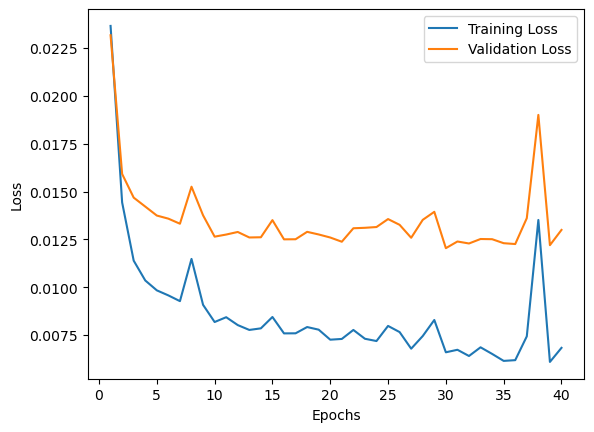

In [14]:
#Best parameters: Learning rate: 0.001, Hidden sizes: [90, 60, 30, 10], Lambda_l2: 0.001, Optimizer: <class '__main__.Nadam'> 
# Train model with best parameters to search number of epochs
# Divido il training test in training e validation (75% of 80% in training and 25% of 80% in validation)
X_train_val, X_valid, y_train_val, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
learning_rate, hidden_sizes, lambda_l2, optimizer = best_params
model = NN(input_size=X_train.shape[1], hidden_sizes=hidden_sizes, output_size=y_train.shape[1], learning_rate=learning_rate, lambda_l2=lambda_l2, optimizer = optimizer)
epochs, train_losses, val_losses = train_model(model, X_train_val.to_numpy(), y_train_val.to_numpy(), X_valid.to_numpy(), y_valid.to_numpy())[1:4]
plot_losses(train_losses, val_losses)

Epoch 1/29, Loss: 0.0349
Epoch 2/29, Loss: 0.0191
Epoch 3/29, Loss: 0.0154
Epoch 4/29, Loss: 0.0139
Epoch 5/29, Loss: 0.0128
Epoch 6/29, Loss: 0.0121
Epoch 7/29, Loss: 0.0113
Epoch 8/29, Loss: 0.0109
Epoch 9/29, Loss: 0.0103
Epoch 10/29, Loss: 0.0103
Epoch 11/29, Loss: 0.0097
Epoch 12/29, Loss: 0.0093
Epoch 13/29, Loss: 0.0092
Epoch 14/29, Loss: 0.0090
Epoch 15/29, Loss: 0.0089
Epoch 16/29, Loss: 0.0087
Epoch 17/29, Loss: 0.0087
Epoch 18/29, Loss: 0.0085
Epoch 19/29, Loss: 0.0081
Epoch 20/29, Loss: 0.0082
Epoch 21/29, Loss: 0.0083
Epoch 22/29, Loss: 0.0079
Epoch 23/29, Loss: 0.0079
Epoch 24/29, Loss: 0.0077
Epoch 25/29, Loss: 0.0076
Epoch 26/29, Loss: 0.0083
Epoch 27/29, Loss: 0.0075
Epoch 28/29, Loss: 0.0073
Epoch 29/29, Loss: 0.0072


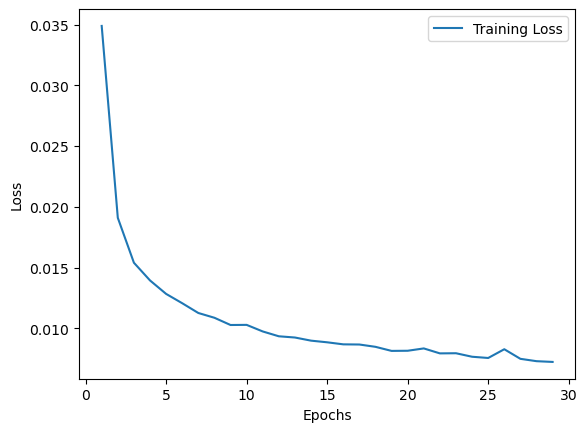

In [15]:
# Train final model with best parameters
model = NN(input_size=X_train.shape[1], hidden_sizes=hidden_sizes, output_size=y_train.shape[1], learning_rate=learning_rate, lambda_l2=lambda_l2, optimizer = optimizer)
train_losses = train_model(model, X_train.to_numpy(), y_train.to_numpy(), epochs=epochs,early_stopping= False)[2]
plot_losses(train_losses)

In [16]:
# Predizione sul test set
results = model.forward(X_test.to_numpy())
m = y_test.to_numpy().shape[0]
model_mse = (1 / m) * np.sum((results - y_test.to_numpy()) ** 2)
model_rmse = np.sqrt(model_mse)
model_rmse

0.13766021469744075

# Dataset Kuzushiji-49

In [17]:
import numpy as np
X_train = np.load('k49-train-imgs.npy')
y = np.load('k49-train-labels.npy')
X_train = X_train.astype(np.float32) / 255.0
# Crea la matrice one-hot encoding
y_train = np.eye(49)[y]
X_test = np.load('k49-test-imgs.npy')
X_test = X_test.astype(np.float32) / 255.0
y_test = np.load('k49-test-label.npy')
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [18]:

# Hyperparameter options
learning_rates = [0.01, 0.001]
lambda_l2_options = [0.01, 0.001]
hidden_layers_options = [
    [500,250],
    [500, 300, 150],
    [600, 400, 200, 100],
    [650, 450, 250, 150, 80]
]
optimizers = [Adam, Nadam]

#best_params = cross_validate(X_train_flat, y_train, learning_rates, hidden_layers_options, optimizers, lambda_l2_options, regression=False, batch_size = 256)

Epoch 1/1000, Loss: 0.4749, Val Loss: 0.5359
Epoch 2/1000, Loss: 0.3156, Val Loss: 0.4084
Epoch 3/1000, Loss: 0.2431, Val Loss: 0.3667
Epoch 4/1000, Loss: 0.1975, Val Loss: 0.3510
Epoch 5/1000, Loss: 0.1569, Val Loss: 0.3394
Epoch 6/1000, Loss: 0.1382, Val Loss: 0.3465
Epoch 7/1000, Loss: 0.1118, Val Loss: 0.3383
Epoch 8/1000, Loss: 0.0926, Val Loss: 0.3380
Epoch 9/1000, Loss: 0.0804, Val Loss: 0.3459
Epoch 10/1000, Loss: 0.0709, Val Loss: 0.3508
Epoch 11/1000, Loss: 0.0716, Val Loss: 0.3689
Epoch 12/1000, Loss: 0.0609, Val Loss: 0.3673
Epoch 13/1000, Loss: 0.0587, Val Loss: 0.3738
Epoch 14/1000, Loss: 0.0623, Val Loss: 0.3912
Epoch 15/1000, Loss: 0.0473, Val Loss: 0.3810
Epoch 16/1000, Loss: 0.0534, Val Loss: 0.3943
Epoch 17/1000, Loss: 0.0488, Val Loss: 0.3996
Epoch 18/1000, Loss: 0.0508, Val Loss: 0.4092
Early stopping


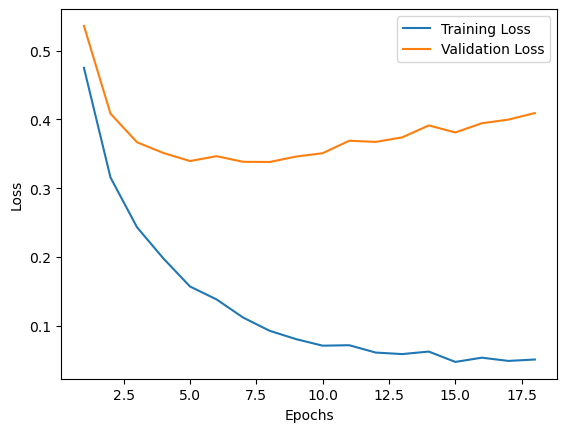

In [19]:
#Learning rate: 0.001, Hidden sizes: [500, 250], Lambda_l2: 0.01, Avg Val Loss: 0.0963, Optimizer: <class '__main__.Nadam'>
# divido il training set in training e validation (75% training, 25% validation)
X_train_val, X_valid, Y_train_val, Y_valid = train_test_split(X_train_flat, y_train, test_size=0.25, random_state=42)
learning_rate, hidden_sizes, lambda_l2, optimizer = 0.001, [500,250],0.01, Nadam
model = NN(input_size=X_train_val.shape[1], hidden_sizes=hidden_sizes, output_size=Y_train_val.shape[1], learning_rate=learning_rate, lambda_l2=lambda_l2,optimizer = optimizer, regression = False)
epochs, train_losses, val_losses = train_model(model, X_train_val, Y_train_val, X_valid, Y_valid, batch_size = 256)[1:4]
plot_losses(train_losses, val_losses)

Epoch 1/7, Loss: 0.4166
Epoch 2/7, Loss: 0.2775
Epoch 3/7, Loss: 0.2189
Epoch 4/7, Loss: 0.1743
Epoch 5/7, Loss: 0.1455
Epoch 6/7, Loss: 0.1253
Epoch 7/7, Loss: 0.1062


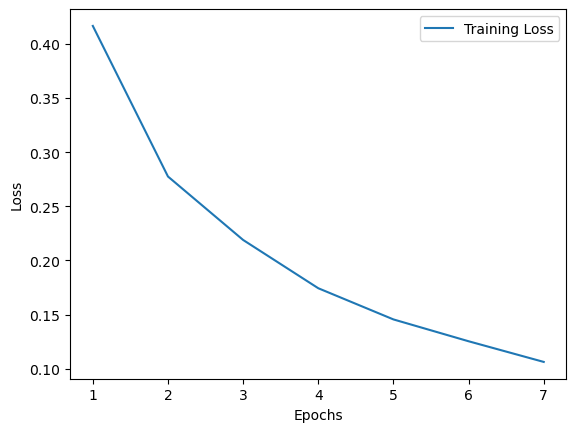

In [20]:
model = NN(input_size=X_train_flat.shape[1], hidden_sizes=hidden_sizes, output_size=y_train.shape[1], learning_rate=learning_rate,optimizer = optimizer, lambda_l2=lambda_l2, regression = False)
train_losses = train_model(model, X_train_flat, y_train, epochs=epochs,early_stopping= False, batch_size=256)[2]
plot_losses(train_losses)

In [21]:
results_softmax = model.forward(X_test_flat)
p_test = np.argmax(results_softmax, axis=1) # Model predictions of class index

accs = []
for cls in range(49):
  mask = (y_test == cls)
  cls_acc = (p_test == cls)[mask].mean() # Accuracy for rows of class cls
  accs.append(cls_acc)
  
accs = np.mean(accs) # Final balanced accuracy
print(f'balanced accuracy: {accs:.4f}')

balanced accuracy: 0.8487
